# Virtual screening of bioassay data

Drug discovery is the first stage of the drug-development process and involves finding compounds to test and screen against biological targets. This first stage is known as primary-screening and usually involves the screening of thousands of compounds.

The bioassay data is a collection of 21 bioassays (screens) that measure the activity of various compounds against different biological targets. This project is mostly based on the [original study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2820499/) of the data.

![Image of Yaktocat](https://i.imgur.com/2bKnxBf.jpg)

In [1]:
import pandas as pd
import numpy as np
import itertools
import os

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

pd.options.display.max_columns = None

import warnings
warnings.simplefilter(action = "ignore")

### Loading and cleaning the data

Each bioassay is split into test and train datasets. Since there are multiple datasets, we will load each to the variables "train" and "test" respectively.

In [2]:
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = pd.read_csv(signal_type_path)
        X_signals.append(file)
    return X_signals 

In [3]:
DATA_PATH_train = "train/"
data_paths_train = os.listdir(DATA_PATH_train)
datasets_train = [DATA_PATH_train + signal for signal in data_paths_train]
train = load_X(datasets_train)

DATA_PATH_test = "test/"
data_paths_test = os.listdir(DATA_PATH_test)
datasets_test = [DATA_PATH_test + signal for signal in data_paths_test]
test = load_X(datasets_test)

In [4]:
print("There are {} train files located at: ".format(len(train)) + DATA_PATH_train + "\n\n" + "Files in directory:")
for i in os.listdir(DATA_PATH_train):
    print(i)

There are 21 train files located at: train/

Files in directory:
AID1284Morered_train.csv
AID1284red_train.csv
AID1608Morered_train.csv
AID1608red_train.csv
AID362red_train.csv
AID373AID439red_train.csv
AID373red_train.csv
AID439Morered_train.csv
AID439red_train.csv
AID456red_train.csv
AID604AID644_AllRed_train.csv
AID604red_train.csv
AID644Morered_train.csv
AID644red_train.csv
AID687AID721red_train.csv
AID687red_train.csv
AID688red_train.csv
AID721morered_train.csv
AID721red_train.csv
AID746AID1284red_train.csv
AID746red_train.csv


In [5]:
print("There are {} test files located at: ".format(len(test)) + DATA_PATH_test + "\n\n" + "Files in directory:")
for i in os.listdir(DATA_PATH_test):
    print(i)

There are 21 test files located at: test/

Files in directory:
AID1284Morered_test.csv
AID1284red_test.csv
AID1608Morered_test.csv
AID1608red_test.csv
AID362red_test.csv
AID373AID439red_test.csv
AID373red_test.csv
AID439Morered_test.csv
AID439red_test.csv
AID456red_test.csv
AID604AID644_AllRed_test.csv
AID604red_test.csv
AID644Morered_test.csv
AID644red_test.csv
AID687AID721red_test.csv
AID687red_test.csv
AID688red_test.csv
AID721morered_test.csv
AID721red_test.csv
AID746AID1284red_test.csv
AID746red_test.csv


Each dataset has a different number of columns (attributes) and compounds. All of them have an "Outcome" column which describes the activity of the compound. This column can have 3 unique values: active, inactive an inconclusive. For simplicity's sake, the inconclusive compounds will be marked as inactive in this project. 

Let's view the characteristics of each dataset by creating a table below.

In [6]:
# Combining train and test datasets
data = []

for i in range(len(train)):
    data.append(pd.concat([train[i], test[i]]))

In [7]:
column_names = [k[:-10] for k in data_paths_train]
n_active,n_rows,n_columns  = [],[],[]

for i in range(len(data)):
    n_active.append((data[i]['Outcome'].value_counts()[1]/data[i].shape[0])*100)
    n_rows.append(data[i].shape[0])
    n_columns.append(data[i].shape[1]-1)
    
# Creating the table
table_n_active = pd.DataFrame({"Number of attributes": n_columns, 
                               "Compounds": n_rows, 
                               "% Active compounds": n_active}, index = column_names)

In [8]:
# Assay description
Primary = ['AID362red',
'AID604red',
'AID456red',
'AID688red',
'AID373red',
'AID746red',
'AID687red']
Primary_and_Confirmatory = ['AID746AID1284red',
'AID604AID644_AllRed',
'AID373AID439red',
'AID687AID721red']
Confirmatory = ['AID1608red',
'AID644red',
'AID1284red',
'AID439Morered',
'AID721morered',
'AID1608Morered',
'AID644Morered',
'AID1284Morered',
'AID439red',
'AID721red']

In [9]:
# Modifying the table
Primary_table = table_n_active.loc[Primary,:]
PrimCom_table = table_n_active.loc[Primary_and_Confirmatory,:]
Com_table = table_n_active.loc[Confirmatory,:]

Primary_table.index = pd.MultiIndex.from_tuples([('Primary', i) for i in Primary])
PrimCom_table.index = pd.MultiIndex.from_tuples([('Primary and Confirmatory', i) for i in Primary_and_Confirmatory])
Com_table.index = pd.MultiIndex.from_tuples([('Confirmatory', i) for i in Confirmatory])

bioassays = pd.concat([Primary_table, PrimCom_table, Com_table])
bioassays.index.names = ['Description', 'Bioassay']
bioassays

Number of attributes  Compounds  \
Description              Bioassay                                               
Primary                  AID362red                             144       4279   
                         AID604red                             154      59788   
                         AID456red                             153       9982   
                         AID688red                             153      27189   
                         AID373red                             155      59788   
                         AID746red                             154      59788   
                         AID687red                             153      33067   
Primary and Confirmatory AID746AID1284red                      154      59784   
                         AID604AID644_AllRed                   154      59782   
                         AID373AID439red                       154      59795   
                         AID687AID721red                       153      33067   
Confirmatory             AID1608red                            154       1033   
                         AID644red                             100        206   
                         AID1284red                            103        362   
                         AID439Morered                         914         69   
                         AID721morered                         914         94   
                         AID1608Morered                        914       1033   
                         AID644Morered                         914        206   
                         AID1284Morered                        914        362   
                         AID439red                              81         69   
                         AID721red                              87         94   

                                              % Active compounds  
Description              Bioassay                                 
Primary                  AID362red                      1.402197  
                         AID604red                      0.354586  
                         AID456red                      0.270487  
                         AID688red                      0.912134  
                         AID373red                      0.103700  
                         AID746red                      0.612163  
                         AID687red                      0.284271  
Primary and Confirmatory AID746AID1284red               0.095343  
                         AID604AID644_AllRed            0.112074  
                         AID373AID439red                0.021741  
                         AID687AID721red                0.063507  
Confirmatory             AID1608red                     6.582769  
                         AID644red                     32.524272  
                         AID1284red                    15.745856  
                         AID439Morered                 18.840580  
                         AID721morered                 22.340426  
                         AID1608Morered                 6.582769  
                         AID644Morered                 32.524272  
                         AID1284Morered                15.745856  
                         AID439red                     18.840580  
                         AID721red                     22.340426

The table shows the description of the assays as well as the number of attrubutes, compounds and the percentage of active compounds. 

From above we notice that the data is unbalanced, with some cases where the active compounds are less than one percent. This means that standard machine learning techniques, which assume equality, are not very effective at building predictive models when there is a low minority class ratio.

In [10]:
# Renaming "Inconclusive" as "Inactive" and replacing the Active and Inactive values with 1's and 0's respectively

mapping = {'Inactive': 0, 'Active': 1}
for i in range(len(train)):
    train[i]['Outcome'] = train[i]['Outcome'].replace(['Inconc', 'Inconclusive'], 'Inactive')
    train[i]['Outcome'] = train[i]['Outcome'].map(mapping)
for i in range(len(test)):
    test[i]['Outcome'] = test[i]['Outcome'].replace(['Inconc', 'Inconclusive'], 'Inactive')
    test[i]['Outcome'] = test[i]['Outcome'].map(mapping)

### Creating models with regular sets

In [11]:
# Train datasets
x, y = [], []
for i in range(len(train)):
    x.append(train[i].drop("Outcome", axis=1))
    y.append(train[i]["Outcome"])

In [12]:
# Test datasets
X_t, y_t = [], []
for i in range(len(test)):
    X_t.append(test[i].drop("Outcome", axis=1))
    y_t.append(test[i]["Outcome"])

In [13]:
# Algorithms
models = []
models.append(('LR', LogisticRegression(random_state=43, class_weight = 'balanced')))
models.append(('SVC', SVC(random_state=43, class_weight = 'balanced')))
models.append(('RFC', RandomForestClassifier(random_state=43, class_weight = 'balanced')))
models.append(('XGB', XGBClassifier()))

For evaluation of the models' performance we will use accuracy, recall and F1 scores:


$$accuracy = \frac{TP + TN}{TP + FN + TN + FP}$$,

$$recall = \frac{TP}{TP + FN}$$,

$$F1 = \frac{2 * precision * recall}{precision + recall}$$

where $TP$ is the number of True Positives, $TN$ is the number of True Negatives, $FN$ is the number of False Negatives and $FP$ is the number of False Positives.

In [14]:
# Function that will create a single table for each bioassay showing the evaluation scores for every algorithm. 
# Each table is appended to a list (t1)
def ml_testing(x,y,xt,yt,t1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    pred_results = []
    recall = []
    f1 = []
    names = []
    for name, model in models:
        # Creating models
        fit_train = model.fit(x_train,y_train)
        names.append(name)
        table1 = pd.DataFrame(index=names)
        # Testing models on the test data
        y_result = model.predict(xt)
        pred_results.append(accuracy_score(yt, y_result))
        table1['Accuracy'] = pred_results
        # Recall scores
        recall.append(recall_score(yt, y_result, labels=[1, 0]))
        table1['Recall'] = recall
        # F1 scores
        f1.append(f1_score(yt, y_result, labels=[1, 0]))
        table1['F1'] = f1
    t1.append(table1)

In [15]:
# Running the function
DF = []
for i in range(len(test)):
    ml_testing(x[i], y[i], X_t[i], y_t[i], DF)

In [16]:
for i in range(len(column_names)):
    DF[i].columns = pd.MultiIndex.from_tuples([(column_names[i],'Accuracy'),
                                               (column_names[i],'Recall'),
                                               (column_names[i],'F1')])

In [17]:
# Concatenating the tables from DF
DF=pd.concat(DF, axis=1)
DF.columns.names = ['Bioassay','Evaluation metric']
DF.index.names = ['Algorithm']

#### Results

Primary screening assays

In [18]:
DF[Primary].T

Algorithm                          LR       SVC       RFC       XGB
Bioassay  Evaluation metric                                        
AID362red Accuracy           0.889019  0.968458  0.987150  0.985981
          Recall             0.583333  0.250000  0.166667  0.000000
          F1                 0.128440  0.181818  0.266667  0.000000
AID604red Accuracy           0.768337  0.975245  0.996487  0.996487
          Recall             0.666667  0.119048  0.000000  0.000000
          F1                 0.019816  0.032680  0.000000  0.000000
AID456red Accuracy           0.940882  0.991984  0.997495  0.997495
          Recall             0.800000  0.000000  0.000000  0.000000
          F1                 0.063492  0.000000  0.000000  0.000000
AID688red Accuracy           0.684994  0.942810  0.990622  0.990805
          Recall             0.280000  0.040000  0.000000  0.000000
          F1                 0.016083  0.012698  0.000000  0.000000
AID373red Accuracy           0.888350  0.996069  0.999080  0.998913
          Recall             0.583333  0.000000  0.083333  0.000000
          F1                 0.010378  0.000000  0.153846  0.000000
AID746red Accuracy           0.723091  0.955173  0.994062  0.993978
          Recall             0.684932  0.205479  0.027397  0.013699
          F1                 0.029317  0.053004  0.053333  0.027027
AID687red Accuracy           0.826403  0.988356  0.997278  0.997127
          Recall             0.277778  0.000000  0.000000  0.000000
          F1                 0.008636  0.000000  0.000000  0.000000

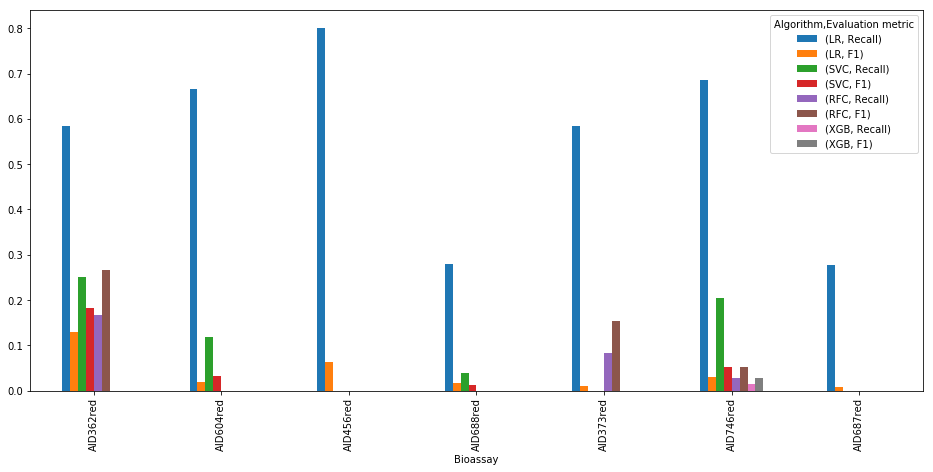

In [20]:
# Barplot (accuracy is dropped)
DF[Primary].drop('Accuracy', axis =1, level=1).T.unstack().plot(kind='bar', figsize = (16,7))

Primary and Confirmatory screening assays

In [21]:
DF[Primary_and_Confirmatory].T

Algorithm                                    LR       SVC       RFC       XGB
Bioassay            Evaluation metric                                        
AID746AID1284red    Accuracy           0.885079  0.997742  0.999080  0.999080
                    Recall             0.727273  0.272727  0.090909  0.000000
                    F1                 0.011511  0.181818  0.153846  0.000000
AID604AID644_AllRed Accuracy           0.872867  0.995316  0.998913  0.998913
                    Recall             0.692308  0.153846  0.000000  0.000000
                    F1                 0.011704  0.066667  0.000000  0.000000
AID373AID439red     Accuracy           0.994481  0.999331  0.999833  0.999833
                    Recall             0.000000  0.000000  0.000000  0.000000
                    F1                 0.000000  0.000000  0.000000  0.000000
AID687AID721red     Accuracy           0.902011  0.998034  0.999395  0.999395
                    Recall             0.000000  0.000000  0.000000  0.000000
                    F1                 0.000000  0.000000  0.000000  0.000000

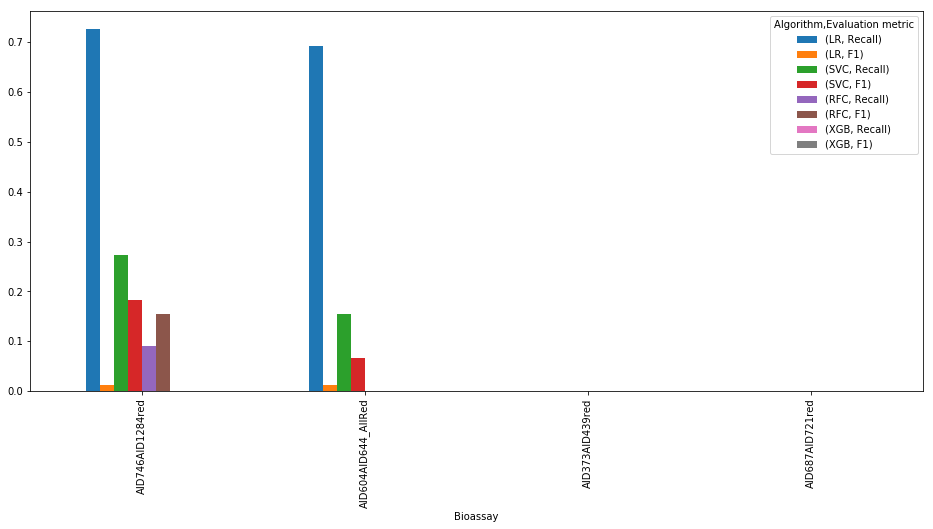

In [22]:
DF[Primary_and_Confirmatory].drop('Accuracy', axis =1, level=1).T.unstack().plot(kind='bar', figsize = (16,7))

Confirmatory screening assays

In [23]:
DF[Confirmatory].T

Algorithm                               LR       SVC       RFC       XGB
Bioassay       Evaluation metric                                        
AID1608red     Accuracy           0.825243  0.878641  0.936893  0.936893
               Recall             0.230769  0.153846  0.000000  0.000000
               F1                 0.142857  0.137931  0.000000  0.000000
AID644red      Accuracy           0.536585  0.609756  0.634146  0.634146
               Recall             0.307692  0.230769  0.076923  0.076923
               F1                 0.296296  0.272727  0.117647  0.117647
AID1284red     Accuracy           0.722222  0.777778  0.861111  0.833333
               Recall             0.545455  0.454545  0.181818  0.181818
               F1                 0.375000  0.384615  0.285714  0.250000
AID439Morered  Accuracy           0.692308  0.615385  0.769231  0.846154
               Recall             0.500000  1.000000  0.000000  0.000000
               F1                 0.333333  0.444444  0.000000  0.000000
AID721morered  Accuracy           0.722222  0.555556  0.722222  0.500000
               Recall             0.250000  0.500000  0.000000  0.000000
               F1                 0.285714  0.333333  0.000000  0.000000
AID1608Morered Accuracy           0.893204  0.660194  0.932039  0.932039
               Recall             0.307692  0.230769  0.076923  0.000000
               F1                 0.266667  0.078947  0.125000  0.000000
AID644Morered  Accuracy           0.658537  0.609756  0.731707  0.658537
               Recall             0.384615  0.461538  0.307692  0.153846
               F1                 0.416667  0.428571  0.421053  0.222222
AID1284Morered Accuracy           0.791667  0.652778  0.861111  0.847222
               Recall             0.545455  0.454545  0.181818  0.272727
               F1                 0.444444  0.285714  0.285714  0.352941
AID439red      Accuracy           0.692308  0.846154  0.846154  0.846154
               Recall             0.500000  0.000000  0.000000  0.000000
               F1                 0.333333  0.000000  0.000000  0.000000
AID721red      Accuracy           0.722222  0.722222  0.722222  0.500000
               Recall             0.500000  0.000000  0.000000  0.000000
               F1                 0.444444  0.000000  0.000000  0.000000

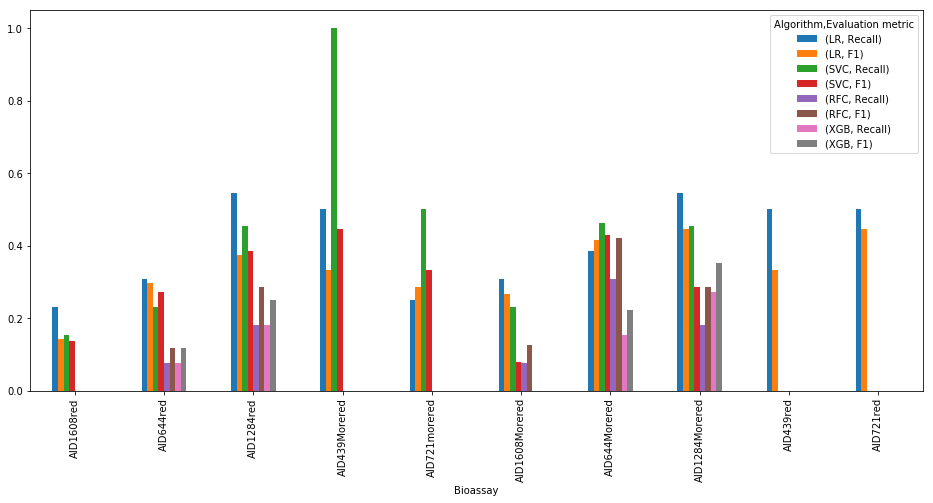

In [24]:
DF[Confirmatory].drop('Accuracy', axis =1, level=1).T.unstack().plot(kind='bar', figsize = (16,7))

A lot of the classifiers have relatively high accuracy scores, but accuracy applies a naive 0.50 threshold to decide between classes, and this is usually wrong when the classes are imbalanced. For instance, the classifier may assume that all outcomes are inactive and get a high accuracy score, but our goal here is to predict which compounds are active.

We get a better understanding of the classifier's performance by reviewing its recall and F1 score.
The bad results indicate that as expected, the quality of the data is poor and that maybe we should try alternative way to improve the models' performances.

### Creating models with undersampled data

Undersampling randomly downsamples the majority class. Below, we will create a ratio of 1:1 between the active and inactive compounds by randomly removing portions of the inactive compounds. This may improve the performance of the classifiers.

In [25]:
active = []
inactive = []
# Number of active and inactive compounds
for i in range(len(train)):
    active.append(len(train[i][train[i]['Outcome'] == 1]))
    inactive.append(train[i][train[i].Outcome == 0].index)

In [26]:
# Random sample of inactive compounds
random_indices = []
for a, i in zip(active, inactive):
    random_indices.append(np.random.choice(i, a, replace=False))

In [27]:
# Finding the indices of active compounds
active_indices = []
for i in range(len(train)):
    active_indices.append(train[i][train[i].Outcome == 1].index)

In [28]:
# Concat active indices with inactive ones
under_sample_indices = []
for i in range(len(random_indices)):
    under_sample_indices.append(np.concatenate([active_indices[i], random_indices[i]]))

In [29]:
# Get Balance Dataframes (under_samples)
under_samples = []
for i in range(len(under_sample_indices)):
    under_samples.append(train[i].iloc[under_sample_indices[i]])

In [30]:
x, y = [], []
for i in range(len(under_samples)):
    x.append(under_samples[i].drop("Outcome", axis=1))
    y.append(under_samples[i]["Outcome"])

In [31]:
# Running the function
DF_undersampled = []
for i in range(len(test)):
    ml_testing(x[i],y[i],X_t[i],y_t[i], DF_undersampled)

In [32]:
for i in range(len(column_names)):
    DF_undersampled[i].columns = pd.MultiIndex.from_tuples([(column_names[i],'Accuracy'),
                                                            (column_names[i],'Recall'),
                                                            (column_names[i],'F1')])

In [33]:
DF_undersampled=pd.concat(DF_undersampled, axis=1)
DF_undersampled.columns.names = ['Bioassay','Evaluation metric']
DF_undersampled.index.names = ['Algorithm']

#### Results

Primary screening assays

In [34]:
DF_undersampled[Primary].T

Algorithm                          LR       SVC       RFC       XGB
Bioassay  Evaluation metric                                        
AID362red Accuracy           0.565421  0.466121  0.655374  0.656542
          Recall             0.833333  0.500000  0.750000  0.666667
          F1                 0.051020  0.025586  0.057508  0.051613
AID604red Accuracy           0.679769  0.637953  0.771682  0.700092
          Recall             0.880952  0.690476  0.595238  0.761905
          F1                 0.018960  0.013221  0.017986  0.017534
AID456red Accuracy           0.527555  0.254008  0.587675  0.535571
          Recall             0.800000  1.000000  0.400000  0.800000
          F1                 0.008412  0.006671  0.004837  0.008556
AID688red Accuracy           0.545973  0.499081  0.653365  0.559581
          Recall             0.460000  0.560000  0.400000  0.480000
          F1                 0.018290  0.020144  0.020779  0.019648
AID373red Accuracy           0.764071  0.616208  0.885506  0.814836
          Recall             0.916667  0.583333  0.500000  0.833333
          F1                 0.007738  0.003041  0.008689  0.008953
AID746red Accuracy           0.640796  0.521285  0.805971  0.733796
          Recall             0.780822  0.602740  0.712329  0.739726
          F1                 0.025856  0.015141  0.042904  0.032817
AID687red Accuracy           0.623771  0.669137  0.758204  0.628610
          Recall             0.444444  0.388889  0.277778  0.444444
          F1                 0.006390  0.006358  0.006215  0.006472

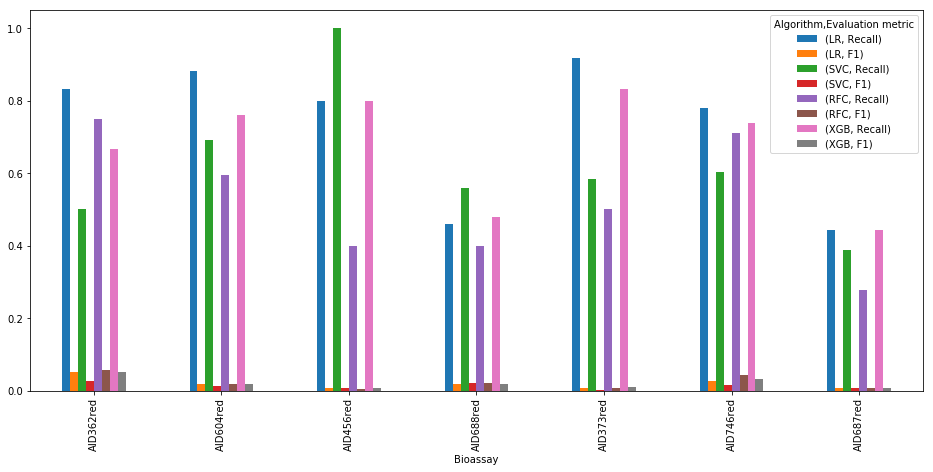

In [35]:
DF_undersampled[Primary].drop('Accuracy', axis =1, level=1).T.unstack().plot(kind='bar', figsize = (16,7))

Primary and confirmatory screening assays

In [36]:
DF_undersampled[Primary_and_Confirmatory].T

Algorithm                                    LR       SVC       RFC       XGB
Bioassay            Evaluation metric                                        
AID746AID1284red    Accuracy           0.673218  0.622533  0.684092  0.664771
                    Recall             0.818182  0.636364  0.727273  0.909091
                    F1                 0.004586  0.003093  0.004218  0.004965
AID604AID644_AllRed Accuracy           0.733941  0.635162  0.790565  0.703914
                    Recall             0.923077  0.538462  0.692308  0.692308
                    F1                 0.007488  0.003199  0.007137  0.005059
AID373AID439red     Accuracy           0.764278  0.752655  0.651559  0.628564
                    Recall             0.500000  1.000000  1.000000  1.000000
                    F1                 0.000709  0.001350  0.000959  0.000900
AID687AID721red     Accuracy           0.593074  0.251172  0.414638  0.407984
                    Recall             0.750000  0.750000  0.750000  0.750000
                    F1                 0.002225  0.001210  0.001548  0.001530

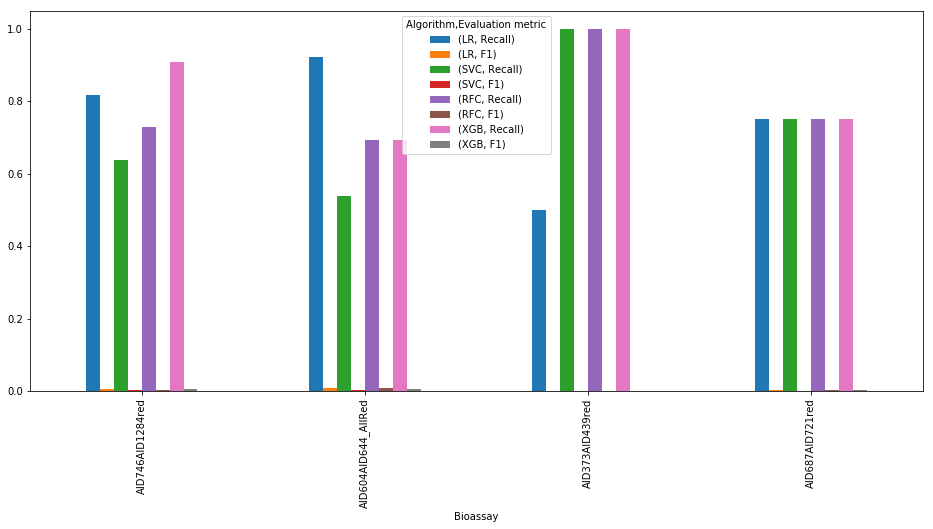

In [37]:
DF_undersampled[Primary_and_Confirmatory].drop('Accuracy', axis =1, level=1).T.unstack().plot(kind='bar', figsize = (16,7))

Confirmatory screening assays

In [38]:
DF_undersampled[Confirmatory].T

Algorithm                               LR       SVC       RFC       XGB
Bioassay       Evaluation metric                                        
AID1608red     Accuracy           0.572816  0.616505  0.723301  0.592233
               Recall             0.307692  0.307692  0.461538  0.384615
               F1                 0.083333  0.091954  0.173913  0.106383
AID644red      Accuracy           0.536585  0.487805  0.560976  0.560976
               Recall             0.307692  0.384615  0.153846  0.384615
               F1                 0.296296  0.322581  0.181818  0.357143
AID1284red     Accuracy           0.736111  0.583333  0.625000  0.611111
               Recall             0.818182  0.545455  0.454545  0.909091
               F1                 0.486486  0.285714  0.270270  0.416667
AID439Morered  Accuracy           0.769231  0.692308  0.615385  0.615385
               Recall             0.500000  1.000000  0.500000  1.000000
               F1                 0.400000  0.500000  0.285714  0.444444
AID721morered  Accuracy           0.444444  0.388889  0.277778  0.444444
               Recall             0.750000  0.500000  0.000000  0.750000
               F1                 0.375000  0.266667  0.000000  0.375000
AID1608Morered Accuracy           0.669903  0.674757  0.742718  0.563107
               Recall             0.461538  0.307692  0.230769  0.538462
               F1                 0.150000  0.106667  0.101695  0.134615
AID644Morered  Accuracy           0.609756  0.512195  0.853659  0.609756
               Recall             0.538462  0.615385  0.769231  0.461538
               F1                 0.466667  0.444444  0.769231  0.428571
AID1284Morered Accuracy           0.583333  0.569444  0.652778  0.555556
               Recall             0.727273  0.636364  0.818182  0.818182
               F1                 0.347826  0.311111  0.418605  0.360000
AID439red      Accuracy           0.923077  0.769231  0.769231  0.538462
               Recall             1.000000  0.500000  0.500000  0.500000
               F1                 0.800000  0.400000  0.400000  0.250000
AID721red      Accuracy           0.555556  0.388889  0.444444  0.388889
               Recall             0.500000  1.000000  0.250000  0.250000
               F1                 0.333333  0.421053  0.166667  0.153846

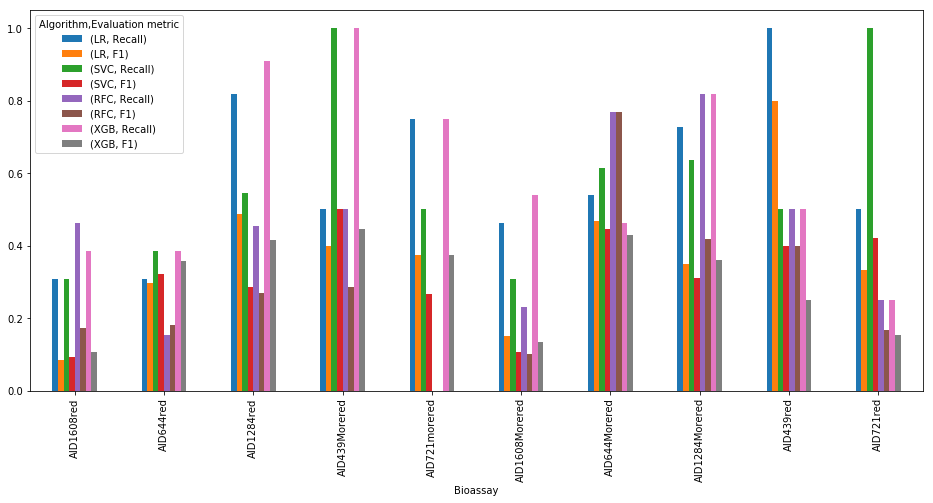

In [39]:
DF_undersampled[Confirmatory].drop('Accuracy', axis =1, level=1).T.unstack().plot(kind='bar', figsize = (16,7))

The performance was improved in most of the cases, but not by a large margin.

### Hyperparameter XGBoost Tuning

Hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. Since tuning every classifier for every bioassay would require a lot of time and computational power, let's examine a single example.

#### Part 1: Untuned model parameters 

In [40]:
train = pd.read_csv('...AID1284Morered_train.csv')
test = pd.read_csv('...AID1284Morered_test.csv')

In [41]:
mapping = {'Inactive': 0, 'Active': 1}
train['Outcome'] = train['Outcome'].map(mapping)
test['Outcome'] = test['Outcome'].map(mapping)

In [42]:
x = train.drop("Outcome", axis=1)
y = train['Outcome']

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [44]:
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
# Train set
XGB = xgb.XGBClassifier()
XGB.fit(x_train, y_train)
predictions = XGB.predict(x_test)
accuracy_score(y_test, predictions)

0.8045977011494253

In [46]:
# Test set
X_t = test.drop("Outcome", axis=1)
y_result = XGB.predict(X_t)
accuracy_score(test["Outcome"], y_result)

0.8472222222222222

In [47]:
# Confusion matrix
XGB_confusion_matrix1 = confusion_matrix(test["Outcome"], y_result, labels=[1, 0])
XGB_confusion_matrix1

array([[ 3,  8],
       [ 3, 58]], dtype=int64)

Confusion matrix (from left to right):

* True positive (TP): correct positive prediction
* False negative (FN): incorrect negative prediction
* False positive (FP): incorrect positive prediction
* True negative (TN): correct negative prediction

In [48]:
# Recall and F1 score
XGB_recall1 = recall_score(test["Outcome"], y_result, labels=[1, 0]) 
XGB_F11 = f1_score(test["Outcome"], y_result, labels=[1, 0])

In [49]:
print('Recall score: ' + str(XGB_recall1), '\nF1 score: ' + str(XGB_F11))

Recall score: 0.2727272727272727 
F1 score: 0.3529411764705882


#### Part 2: Tuning

In [50]:
XGB1 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=1000,
                         max_depth=5, 
                         min_child_weight=1, 
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic', 
                         nthread=4,scale_pos_weight=1,seed=27)
XGB1.fit(x_train, y_train)
predictions = XGB1.predict(x_test)
accuracy_score(y_test, predictions)

0.8160919540229885

In [51]:
y_result = XGB1.predict(X_t)
accuracy_score(test["Outcome"], y_result)

0.8611111111111112

In [52]:
# Step 1: Tune max_depth and min_child_weight
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch1.fit(x_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.5652100840336135)

The optimal parameter for max_depth is 3, while the optimal parameter for min_child_weight is 1.

In [53]:
# Fix new parameters with optimal parameters
XGB2 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=1000,
                         max_depth=3, 
                         min_child_weight=1, 
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic', 
                         nthread=4,
                         scale_pos_weight=1,
                         seed=27)
XGB2.fit(x_train, y_train)
predictions = XGB2.predict(x_test)
accuracy_score(y_test, predictions)

0.8045977011494253

In [54]:
y_result = XGB2.predict(X_t)
accuracy_score(test["Outcome"], y_result)

0.8611111111111112

In [55]:
# Step 2: Tune gamma value using the parameters already tuned above.
param_test2 = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth = 3,
                                                  min_child_weight = 1,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch2.fit(x_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.4}, 0.5844817927170868)

In [56]:
# Fix new parameter with optimal parameter
XGB3 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=1000,
                         max_depth=3, 
                         min_child_weight=1, 
                         gamma=0.4,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic', 
                         nthread=4,
                         scale_pos_weight=1,
                         seed=27)
XGB3.fit(x_train, y_train)
predictions = XGB3.predict(x_test)
accuracy_score(y_test, predictions)

0.7931034482758621

In [57]:
y_result = XGB3.predict(X_t)
accuracy_score(test["Outcome"], y_result)

0.8472222222222222

In [58]:
#Step 3: Tune subsample and colsample_bytree
param_test3 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                                                  max_depth = 3,
                                                  min_child_weight = 1,
                                                  gamma=0.4, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch3.fit(x_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.6212885154061625)

In [59]:
XGB4 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=1000,
                         max_depth=3, 
                         min_child_weight=1, 
                         gamma=0.4,
                         subsample=0.9,
                         colsample_bytree=0.6,
                         objective= 'binary:logistic', 
                         nthread=4,
                         scale_pos_weight=1,
                         seed=27)
XGB4.fit(x_train, y_train)
predictions = XGB4.predict(x_test)
accuracy_score(y_test, predictions)

0.7931034482758621

In [60]:
y_result = XGB4.predict(X_t)
accuracy_score(test["Outcome"], y_result)

0.8472222222222222

In [61]:
# Refining the research
param_test4 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth = 3,
                                                  min_child_weight = 5,
                                                  gamma=0.2, 
                                                  subsample=0.9, 
                                                  colsample_bytree=0.6,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch4.fit(x_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.55}, 0.5757703081232493)

In [62]:
# Fix new param with optimal parameter
XGB5 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=1000,
                         max_depth=3, 
                         min_child_weight=1, 
                         gamma=0.4,
                         subsample=0.55,
                         colsample_bytree=0.9,
                         objective= 'binary:logistic', 
                         nthread=4,
                         scale_pos_weight=1,
                         seed=27)
XGB5.fit(x_train, y_train)
predictions = XGB5.predict(x_test)
accuracy_score(y_test, predictions)

0.8045977011494253

In [63]:
y_result = XGB5.predict(X_t)
accuracy_score(test["Outcome"], y_result)

0.875

In [64]:
#Step 3: tuning learning_rate
param_test5 = {
 'learning_rate':[i/1000.0 for i in range(5,20,2)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  gamma=0.4,
                                                  subsample=0.55,
                                                  colsample_bytree=0.85,
                                                  max_depth = 3,
                                                  min_child_weight = 5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch5.fit(x_train, y_train)
gsearch5.best_params_, gsearch5.best_score_

({'learning_rate': 0.019}, 0.5797759103641457)

In [65]:
# Final model
XGB6 = xgb.XGBClassifier(learning_rate =0.019, 
                         n_estimators=1000,
                         max_depth=3, 
                         min_child_weight=1, 
                         gamma=0.4,
                         subsample=0.55,
                         colsample_bytree=0.9,
                         objective= 'binary:logistic', 
                         nthread=4,
                         scale_pos_weight=1,
                         seed=27)
XGB6.fit(x_train, y_train)
predictions = XGB6.predict(x_test)
accuracy_score(y_test, predictions)

0.8045977011494253

In [66]:
y_result = XGB6.predict(X_t)
accuracy_score(test["Outcome"], y_result)

0.8611111111111112

Scores:

In [67]:
XGB_recall2 = recall_score(test["Outcome"], y_result, labels=[1, 0])
XGB_F12 = f1_score(test["Outcome"], y_result, labels=[1, 0])

In [68]:
print('Old recall score: ' + str(XGB_recall1), '\nNew recall score: ' + str(XGB_recall2))

Old recall score: 0.2727272727272727 
New recall score: 0.36363636363636365


In [69]:
print('Old F1 score: ' + str(XGB_F11), '\nNew F1 score: ' + str(XGB_F12))

Old F1 score: 0.3529411764705882 
New F1 score: 0.4444444444444444


Both the recall and F1 score improved.

In [70]:
# Confusion matrix
XGB_confusion_matrix2 = confusion_matrix(test["Outcome"], y_result, labels=[1, 0])

In [71]:
# Old
XGB_confusion_matrix1

array([[ 3,  8],
       [ 3, 58]], dtype=int64)

In [72]:
# New
XGB_confusion_matrix2

array([[ 4,  7],
       [ 3, 58]], dtype=int64)

By tuning, we managed to gain one true positive.

Unfortunately, pharmaceutical data is hard to obtain and this particular one is of poor quality. The bad results from primary screening leads to the issue of whether this type of data should be used for virtual screening.